In [4]:
#load all the required libraries
import pandas as pd #Analysis 
import matplotlib.pyplot as plt #Visulization
import seaborn as sns #Visulization
import numpy as np #Analysis 
from scipy.stats import norm #Analysis 
from sklearn.preprocessing import StandardScaler #Analysis 
from scipy import stats #Analysis 
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline
import gc

import os
import string
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

In [5]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: scipy in c:\users\yashu\anaconda3\lib\site-packages (from lightgbm) (1.5.2)



In [6]:
df_train = pd.read_csv("drugsComTrain_raw.csv", parse_dates=["date"])
df_test = pd.read_csv("drugsComTest_raw.csv", parse_dates=["date"])

In [7]:
print("unique values count of train : " ,len(set(df_train['uniqueID'].values)))
print("length of train : " ,df_train.shape[0])

unique values count of train :  161297
length of train :  161297


In [8]:
df_all = pd.concat([df_train,df_test])

Text(0.5, 1.0, 'Top20 : The number of drugs per condition.')

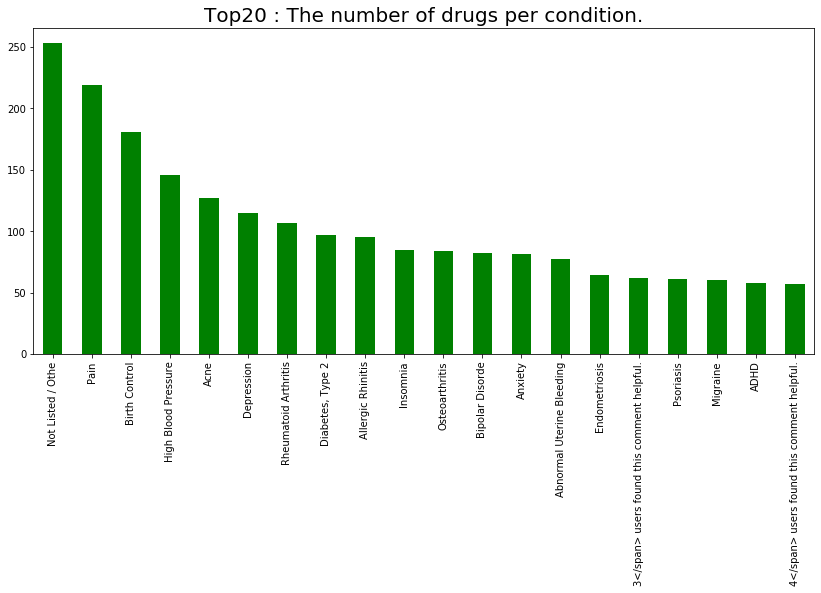

In [9]:
condition_dn = df_all.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
condition_dn[0:20].plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Top20 : The number of drugs per condition.", fontsize = 20)

In [10]:
df_all[df_all['condition']=='3</span> users found this comment helpful.'].head(3)

,uniqueID,drugName,condition,review,rating,date,usefulCount
243,81588,Yaz,3</span> users found this comment helpful.,"""I took Yaz for a little over 2 years. From a...",3,2010-06-01,3
1864,124318,Skyla,3</span> users found this comment helpful.,"""Never pregnant,28,retroverted small (6cm) ute...",1,2015-12-16,3
3322,202848,ProAir HFA,3</span> users found this comment helpful.,"""I get chest colds and asthmatic symptoms in t...",9,2015-12-12,3


Text(0.5, 1.0, 'Bottom20 : The number of drugs per condition.')

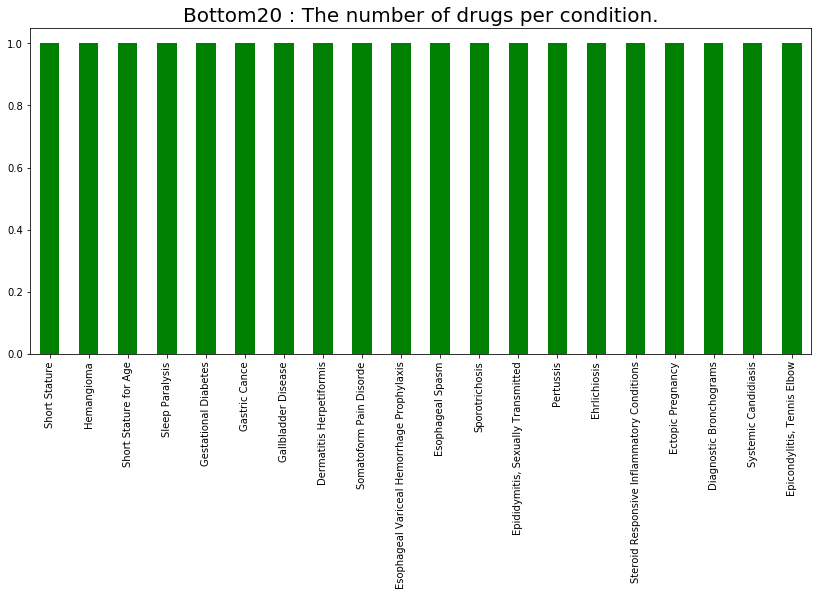

In [11]:
condition_dn = df_all.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)

condition_dn[condition_dn.shape[0]-20:condition_dn.shape[0]].plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Bottom20 : The number of drugs per condition.", fontsize = 20)

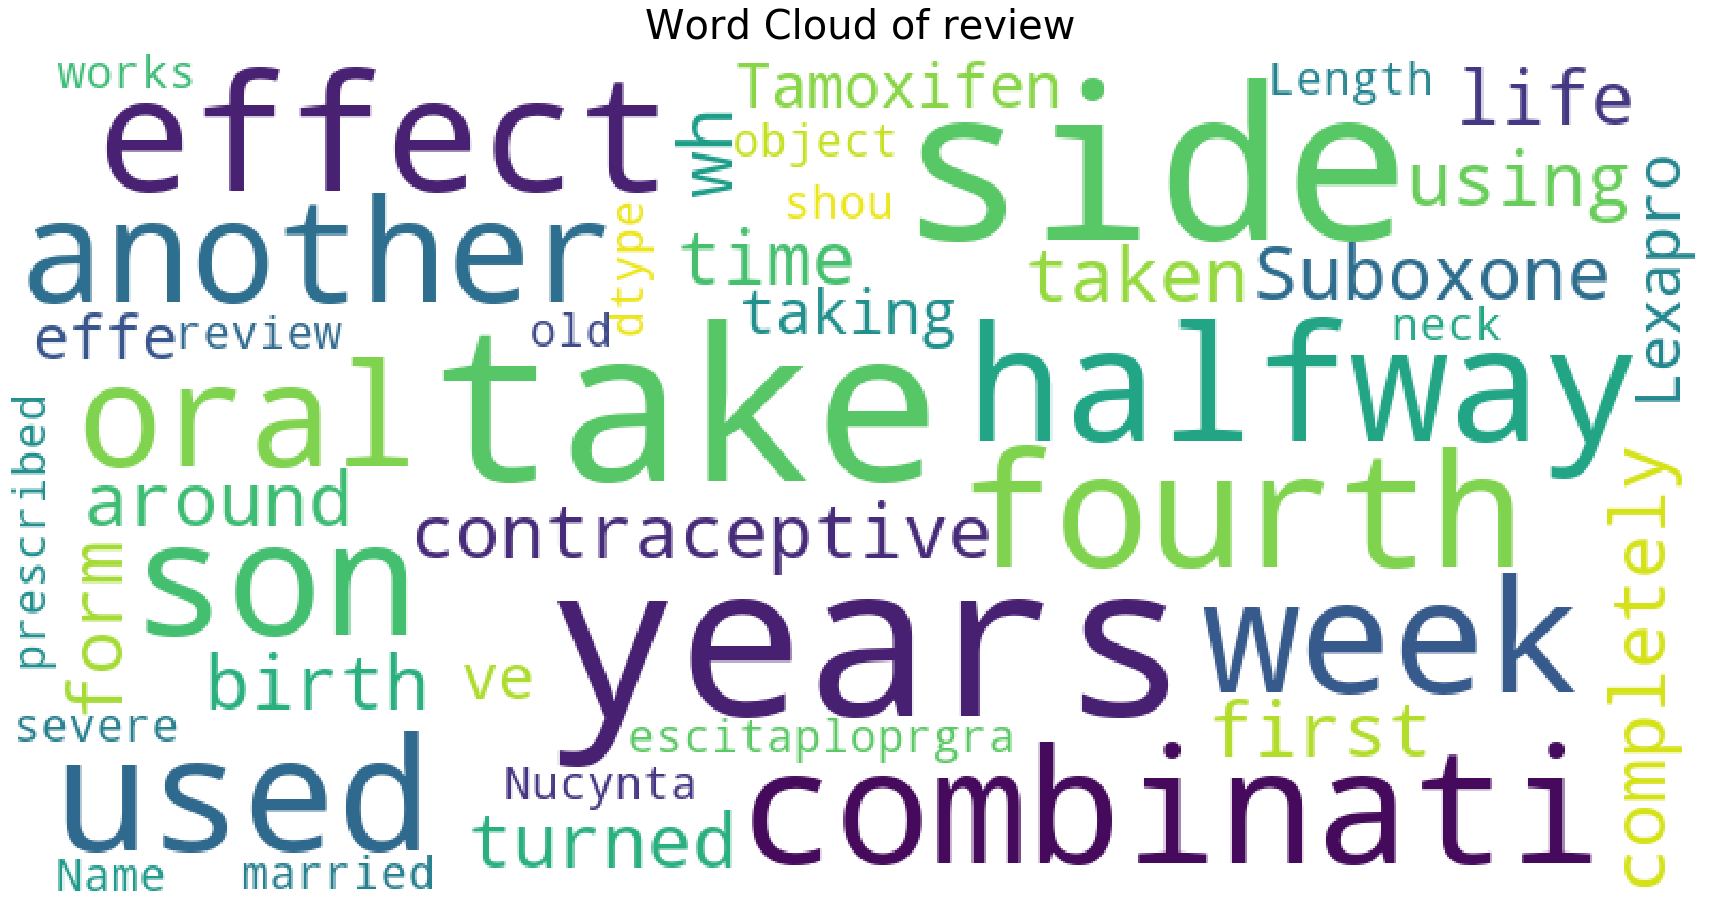

In [12]:
#https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc kernel 
from wordcloud import WordCloud, STOPWORDS

# Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(df_all["review"], title="Word Cloud of review")

In [13]:
from collections import defaultdict
df_all_6_10 = df_all[df_all["rating"]>5]
df_all_1_5 = df_all[df_all["rating"]<6]

In [14]:
## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Get the bar chart from rating  8 to 10 review ##
freq_dict = defaultdict(int)
for sent in df_all_1_5["review"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

## Get the bar chart from rating  4 to 7 review ##
freq_dict = defaultdict(int)
for sent in df_all_6_10["review"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of rating 1 to 5", 
                                          "Frequent words of rating 6 to 10"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots')

C:\Users\yashu\Anaconda3\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [15]:
freq_dict = defaultdict(int)
for sent in df_all_1_5["review"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'orange')

freq_dict = defaultdict(int)
for sent in df_all_6_10["review"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(50), 'orange')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent biagrams of rating 1 to 5", 
                                          "Frequent biagrams of rating 6 to 10"])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig['layout'].update(height=1200, width=1000, paper_bgcolor='rgb(233,233,233)', title="Bigram Count Plots")
py.iplot(fig, filename='word-plots')

In [16]:
freq_dict = defaultdict(int)
for sent in df_all_1_5["review"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'green')

freq_dict = defaultdict(int)
for sent in df_all_6_10["review"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(50), 'green')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent trigrams of rating 1 to 5", 
                                          "Frequent trigrams of rating 6 to 10"])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig['layout'].update(height=1200, width=1600, paper_bgcolor='rgb(233,233,233)', title="Trigram Count Plots")
py.iplot(fig, filename='word-plots')

In [17]:
freq_dict = defaultdict(int)
for sent in df_all_1_5["review"]:
    for word in generate_ngrams(sent,4):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'red')

freq_dict = defaultdict(int)
for sent in df_all_6_10["review"]:
    for word in generate_ngrams(sent,4):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(50), 'red')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent 4-grams of rating 1 to 5", 
                                          "Frequent 4-grams of rating 6 to 10"])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig['layout'].update(height=1200, width=1600, paper_bgcolor='rgb(233,233,233)', title="4-grams Count Plots")
py.iplot(fig, filename='word-plots')

Text(0.5, 1.0, 'Count of rating values')

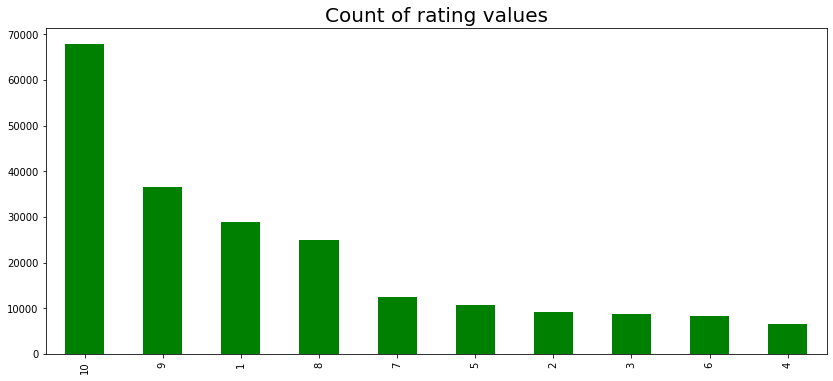

In [18]:
rating = df_all['rating'].value_counts().sort_values(ascending=False)
rating.plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Count of rating values", fontsize = 20)

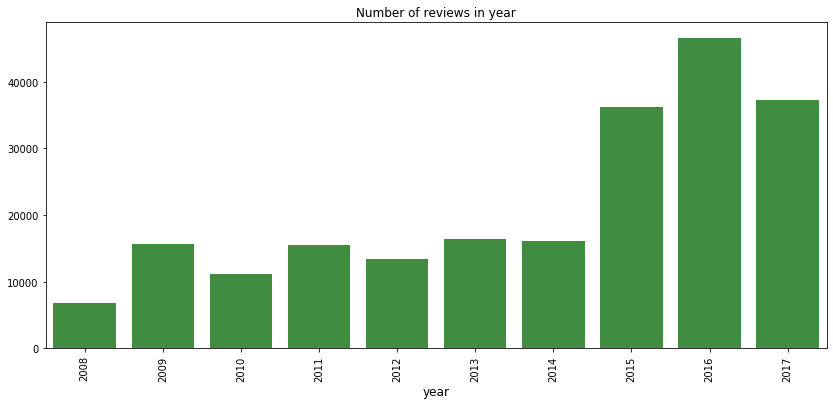

In [19]:
cnt_srs = df_all['date'].dt.year.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('year', fontsize=12)
plt.ylabel('', fontsize=12)
plt.title("Number of reviews in year")
plt.show()

Text(0.5, 1.0, 'Mean rating in year')

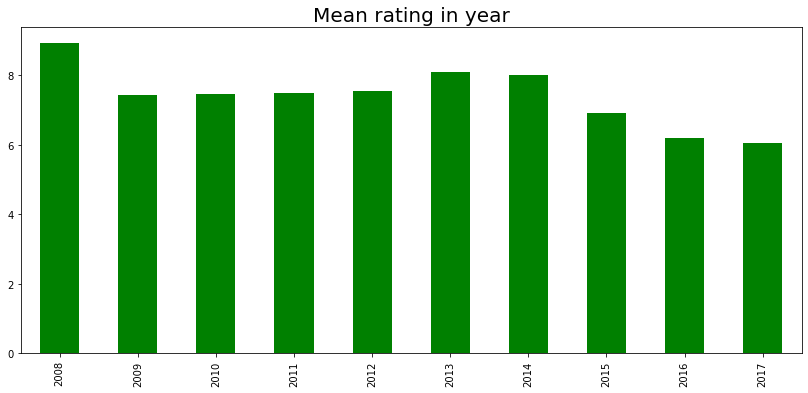

In [20]:
df_all['year'] = df_all['date'].dt.year
rating = df_all.groupby('year')['rating'].mean()
rating.plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Mean rating in year", fontsize = 20)

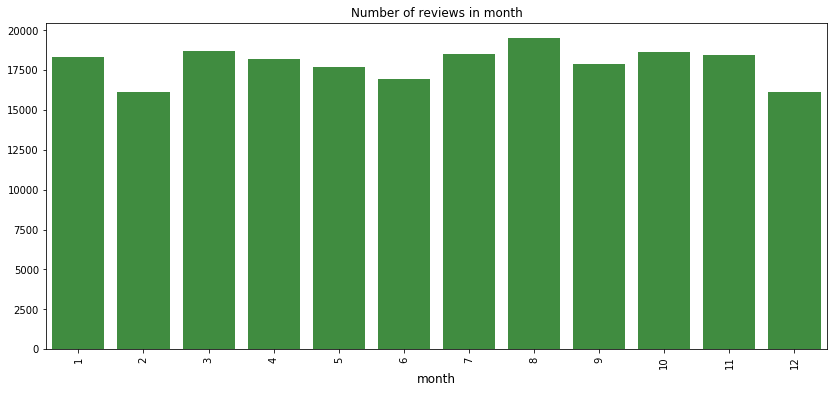

In [21]:
cnt_srs = df_all['date'].dt.month.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('month', fontsize=12)
plt.ylabel('', fontsize=12)
plt.title("Number of reviews in month")
plt.show()

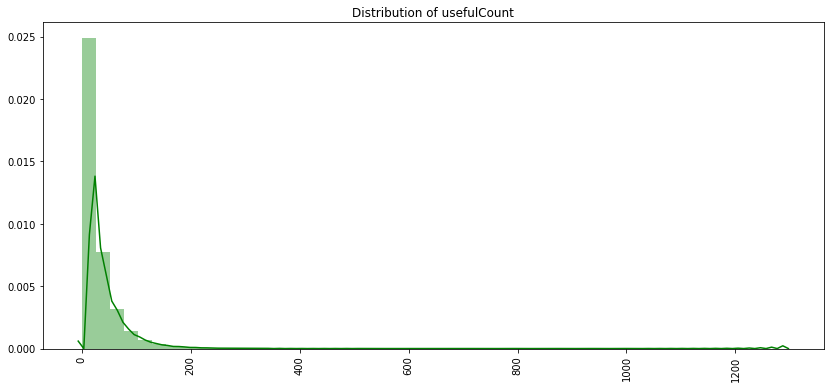

In [22]:
plt.figure(figsize=(14,6))
sns.distplot(df_all["usefulCount"].dropna(),color="green")
plt.xticks(rotation='vertical')
plt.xlabel('', fontsize=12)
plt.ylabel('', fontsize=12)
plt.title("Distribution of usefulCount")
plt.show()

In [23]:
df_all["usefulCount"].describe()

count    215063.000000
mean         28.001004
std          36.346069
min           0.000000
25%           6.000000
50%          16.000000
75%          36.000000
max        1291.000000
Name: usefulCount, dtype: float64

Text(0.5, 1.0, 'Total Missing Value ')

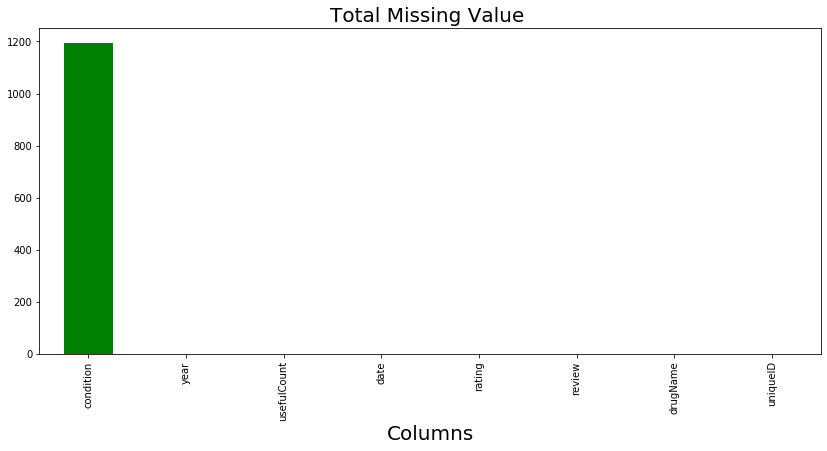

In [24]:
percent = (df_all.isnull().sum()).sort_values(ascending=False)
percent.plot(kind="bar", figsize = (14,6), fontsize = 10, color='green')
plt.xlabel("Columns", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Total Missing Value ", fontsize = 20)

In [25]:
print("Missing value (%):", 1200/df_all.shape[0] *100)


Missing value (%): 0.5579760349292998


In [26]:
df_train = df_train.dropna(axis=0)
df_test = df_test.dropna(axis=0)

Text(0.5, 1.0, 'Total Missing Value ')

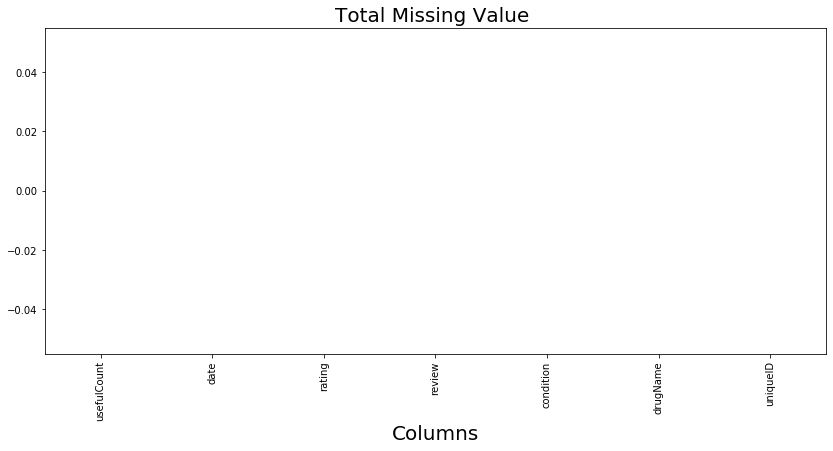

In [27]:
df_all = pd.concat([df_train,df_test]).reset_index()
del df_all['index']
percent = (df_all.isnull().sum()).sort_values(ascending=False)
percent.plot(kind="bar", figsize = (14,6), fontsize = 10, color='green')
plt.xlabel("Columns", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Total Missing Value ", fontsize = 20)

In [28]:
all_list = set(df_all.index)
span_list = []
for i,j in enumerate(df_all['condition']):
    if '</span>' in j:
        span_list.append(i)

In [29]:
new_idx = all_list.difference(set(span_list))
df_all = df_all.iloc[list(new_idx)].reset_index()
del df_all['index']

In [30]:
df_condition = df_all.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
df_condition = pd.DataFrame(df_condition).reset_index()
df_condition.tail(20)

,condition,drugName
816,Hemangioma,1
817,Q Feve,1
818,Urinary Retention,1
819,Diagnostic Bronchograms,1
820,Steroid Responsive Inflammatory Conditions,1
821,Cluster-Tic Syndrome,1
822,Nausea (phosphorated carbohydrate solution),1
823,Ramsay Hunt Syndrome,1
824,Rat-bite Feve,1
825,Hemorrhoids (pramoxine / zinc oxide),1


In [31]:
df_condition_1 = df_condition[df_condition['drugName']==1].reset_index()
df_condition_1['condition'][0:10]

0                           Uveitis, Posteri
1                    Pseudogout, Prophylaxis
2                        Infectious Diarrhea
3                   Thyroid Suppression Test
4                                 Angioedema
5                                Scleroderma
6                                        mis
7            Anti NMDA Receptor Encephalitis
8                                     mist (
9    Pruritus of Partial Biliary Obstruction
Name: condition, dtype: object

In [32]:
all_list = set(df_all.index)
condition_list = []
for i,j in enumerate(df_all['condition']):
    for c in list(df_condition_1['condition']):
        if j == c:
            condition_list.append(i)
            
new_idx = all_list.difference(set(condition_list))
df_all = df_all.iloc[list(new_idx)].reset_index()
del df_all['index']

In [33]:
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

In [34]:
stops = set(stopwords.words('english'))

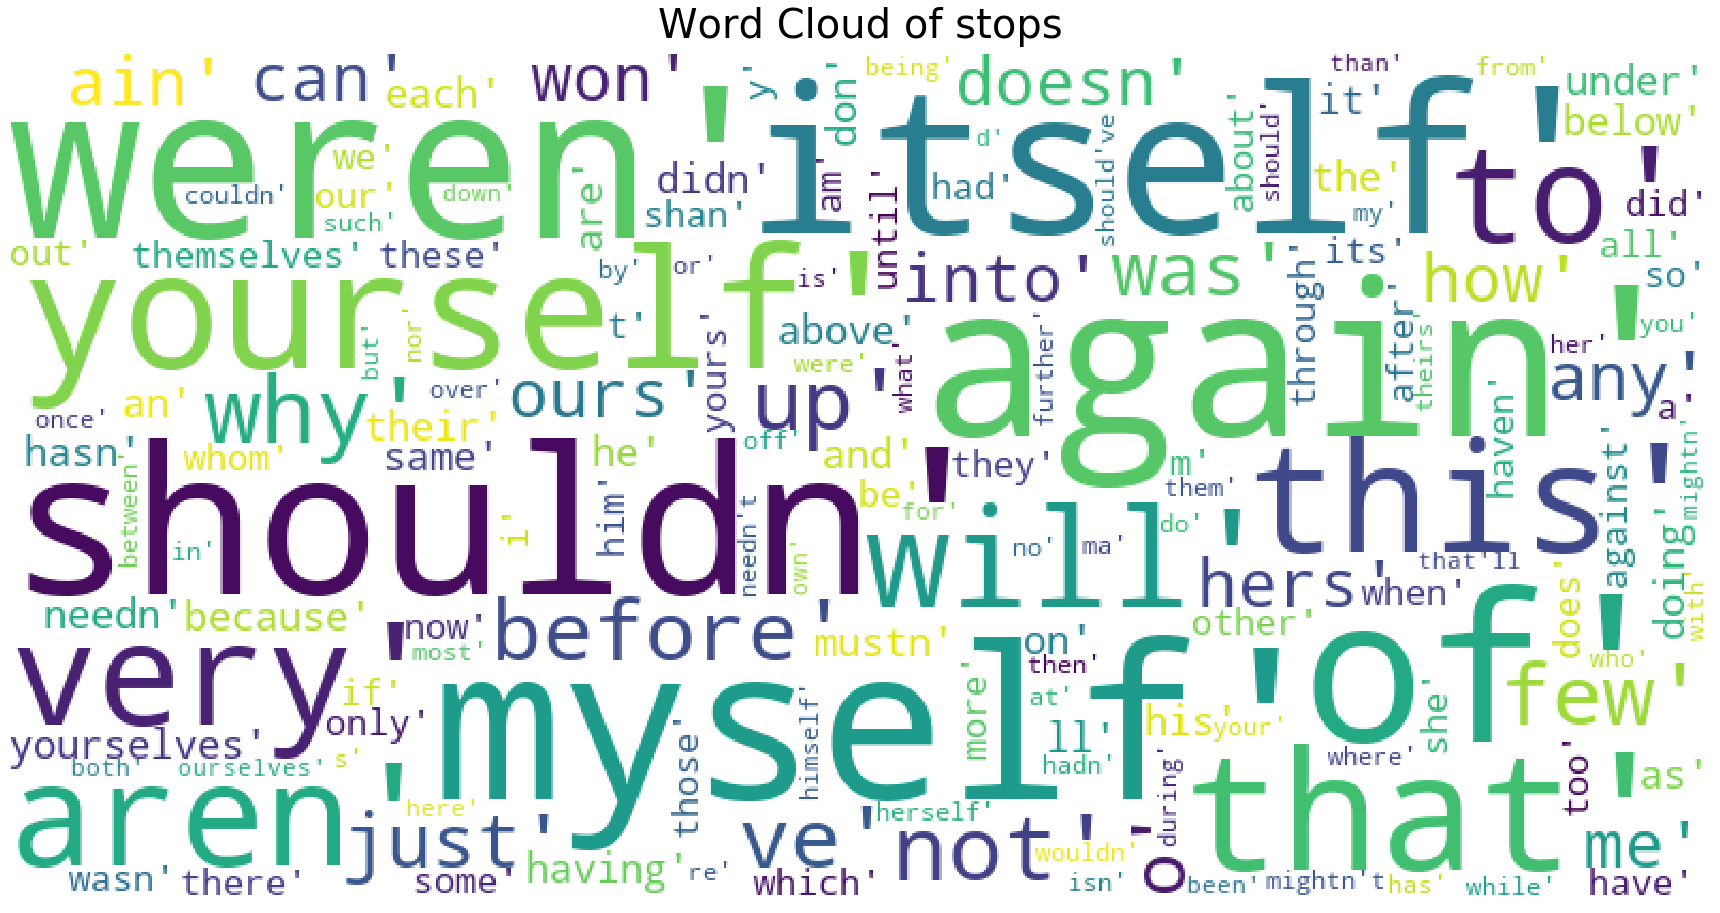

In [35]:
from wordcloud import WordCloud, STOPWORDS

# Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(stops, title="Word Cloud of stops")

In [36]:
not_stop = ["aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't","mightn't","mustn't","needn't","no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"]
for i in not_stop:
    stops.remove(i)

In [37]:
from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999
from bs4 import BeautifulSoup
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

In [38]:
stemmer = SnowballStemmer('english')

def review_to_words(raw_review):
    # 1. Delete HTML 
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. Make a space
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. lower letters
    words = letters_only.lower().split()
    # 5. Stopwords 
    meaningful_words = [w for w in words if not w in stops]
    # 6. Stemming
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    # 7. space join words
    return( ' '.join(stemming_words))

In [39]:
%time df_all['review_clean'] = df_all['review'].apply(review_to_words)

Wall time: 5min 38s


## Model
### Deep Learning Model Using N-gram

In [40]:
# Make a rating
df_all['sentiment'] = df_all["rating"].apply(lambda x: 1 if x > 5 else 0)

In [41]:
df_train, df_test = train_test_split(df_all, test_size=0.33, random_state=42) 

In [42]:
# https://github.com/corazzon/KaggleStruggle/blob/master/word2vec-nlp-tutorial/tutorial-part-1.ipynb
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

vectorizer = CountVectorizer(analyzer = 'word', 
                             tokenizer = None,
                             preprocessor = None, 
                             stop_words = None, 
                             min_df = 2, # 토큰이 나타날 최소 문서 개수
                             ngram_range=(4, 4),
                             max_features = 20000
                            )
vectorizer

CountVectorizer(max_features=20000, min_df=2, ngram_range=(4, 4))

In [43]:
#https://stackoverflow.com/questions/28160335/plot-a-document-tfidf-2d-graph
pipeline = Pipeline([
    ('vect', vectorizer),
])

In [44]:
%time train_data_features = pipeline.fit_transform(df_train['review_clean'])
%time test_data_features = pipeline.fit_transform(df_test['review_clean'])

Wall time: 49.4 s
Wall time: 25.1 s


In [45]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Bidirectional, LSTM, BatchNormalization, Dropout
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

In [46]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
import random

# 1. Dataset
y_train = df_train['sentiment']
y_test = df_test['sentiment']
solution = y_test.copy()

# 2. Model Structure
model = keras.models.Sequential()

model.add(keras.layers.Dense(200, input_shape=(20000,)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(300))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

# 3. Model compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               4000200   
_________________________________________________________________
batch_normalization (BatchNo (None, 200)               800       
_________________________________________________________________
activation (Activation)      (None, 200)               0         
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               60300     
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
activation_1 (Activation)    (None, 300)               0

In [ ]:
# 4. Train model
hist = model.fit(train_data_features, y_train, epochs=10, batch_size=64)

# 5. Traing process
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.set_ylim([0.0, 1.0])
acc_ax.set_ylim([0.0, 1.0])

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
acc_ax.plot(hist.history['acc'], 'b', label='train acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# 6. Evaluation
loss_and_metrics = model.evaluate(test_data_features, y_test, batch_size=32)
print('loss_and_metrics : ' + str(loss_and_metrics))

In [ ]:
sub_preds_deep = model.predict(test_data_features,batch_size=32)

### Lightgbm

In [49]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix

#folds = KFold(n_splits=5, shuffle=True, random_state=546789)
target = df_train['sentiment']
feats = ['usefulCount']

sub_preds = np.zeros(df_test.shape[0])

trn_x, val_x, trn_y, val_y = train_test_split(df_train[feats], target, test_size=0.2, random_state=42) 
feature_importance_df = pd.DataFrame() 
    
clf = LGBMClassifier(
        n_estimators=2000,
        learning_rate=0.05,
        num_leaves=30,
        #colsample_bytree=.9,
        subsample=.9,
        max_depth=7,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2,
        silent=-1,
        verbose=-1,
        )
        
clf.fit(trn_x, trn_y, 
        eval_set= [(trn_x, trn_y), (val_x, val_y)], 
        verbose=100, early_stopping_rounds=100  #30
    )

sub_preds = clf.predict(df_test[feats])
        
fold_importance_df = pd.DataFrame()
fold_importance_df["feature"] = feats
fold_importance_df["importance"] = clf.feature_importances_
feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.570406	valid_1's binary_logloss: 0.572235
[200]	training's binary_logloss: 0.570155	valid_1's binary_logloss: 0.572264
Early stopping, best iteration is:
[100]	training's binary_logloss: 0.570406	valid_1's binary_logloss: 0.572235


In [50]:
solution = df_test['sentiment']
confusion_matrix(y_pred=sub_preds, y_true=solution)

array([[    0, 21009],
       [    0, 48969]], dtype=int64)

In [51]:
len_train = df_train.shape[0]
df_all = pd.concat([df_train,df_test])
del df_train, df_test;
gc.collect()

881

In [52]:
df_all['date'] = pd.to_datetime(df_all['date'])
df_all['day'] = df_all['date'].dt.day
df_all['year'] = df_all['date'].dt.year
df_all['month'] = df_all['date'].dt.month

In [54]:
pip install TextBlob

In [55]:
from textblob import TextBlob
from tqdm import tqdm
reviews = df_all['review_clean']

Predict_Sentiment = []
for review in tqdm(reviews):
    blob = TextBlob(review)
    Predict_Sentiment += [blob.sentiment.polarity]
df_all["Predict_Sentiment"] = Predict_Sentiment
df_all.head()

100%|██████████| 212053/212053 [02:26<00:00, 1447.24it/s]


,uniqueID,drugName,condition,review,rating,date,usefulCount,review_clean,sentiment,day,year,month,Predict_Sentiment
130185,66913,Seroquel,Generalized Anxiety Disorde,"""After trying nearly every SSRI on the market ...",9,2010-11-26,102,tri near everi ssri market place pristiq impro...,1,26,2010,11,0.023958
155501,222222,Fluconazole,"Onychomycosis, Toenail","""This takes 6+ months, but did clear up a deca...",9,2008-05-03,39,take month clear decad long infect,1,3,2008,5,0.025000
75325,75807,Temazepam,Insomnia,"""Worked for awhile pretty well but then went b...",2,2016-04-21,15,work awhil pretti well went back mayb get hour...,0,21,2016,4,-0.125000
19174,229747,Ketamine,Pain,"""I was given this after surgery for pain as I ...",1,2016-04-16,19,given surgeri pain morphin tri drug sort omg w...,0,16,2016,4,0.166667
209735,102495,Aripiprazole,Major Depressive Disorde,"""Abilify served me well over a two month perio...",9,2016-12-16,5,abilifi serv well two month period antidepress...,1,16,2016,12,0.038889


In [56]:
np.corrcoef(df_all["Predict_Sentiment"], df_all["rating"])

array([[1.        , 0.25709864],
       [0.25709864, 1.        ]])

In [57]:
np.corrcoef(df_all["Predict_Sentiment"], df_all["sentiment"])

array([[1.        , 0.23518272],
       [0.23518272, 1.        ]])

In [58]:
reviews = df_all['review']

Predict_Sentiment = []
for review in tqdm(reviews):
    blob = TextBlob(review)
    Predict_Sentiment += [blob.sentiment.polarity]
df_all["Predict_Sentiment2"] = Predict_Sentiment

100%|██████████| 212053/212053 [04:31<00:00, 780.02it/s] 


In [59]:
np.corrcoef(df_all["Predict_Sentiment2"], df_all["rating"])

array([[1.        , 0.34831213],
       [0.34831213, 1.        ]])

In [60]:
np.corrcoef(df_all["Predict_Sentiment2"], df_all["sentiment"])

array([[1.        , 0.31714515],
       [0.31714515, 1.        ]])

In [61]:
df_all['count_sent']=df_all["review"].apply(lambda x: len(re.findall("\n",str(x)))+1)

#Word count in each comment
df_all['count_word']=df_all["review_clean"].apply(lambda x: len(str(x).split()))

#Unique word count(unique)
df_all['count_unique_word']=df_all["review_clean"].apply(lambda x: len(set(str(x).split())))

#Letter count
df_all['count_letters']=df_all["review_clean"].apply(lambda x: len(str(x)))

#punctuation count
df_all["count_punctuations"] = df_all["review"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

#upper case words count
df_all["count_words_upper"] = df_all["review"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

#title case words count
df_all["count_words_title"] = df_all["review"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

#Number of stopwords
df_all["count_stopwords"] = df_all["review"].apply(lambda x: len([w for w in str(x).lower().split() if w in stops]))

#Average length of the words
df_all["mean_word_len"] = df_all["review_clean"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [62]:
df_all['season'] = df_all["month"].apply(lambda x: 1 if ((x>2) & (x<6)) else(2 if (x>5) & (x<9) else (3 if (x>8) & (x<12) else 4)))

In [63]:
df_train = df_all[:len_train]
df_test = df_all[len_train:]

In [64]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier

#folds = KFold(n_splits=5, shuffle=True, random_state=546789)
target = df_train['sentiment']
feats = ['usefulCount','day','year','month','Predict_Sentiment','Predict_Sentiment2', 'count_sent',
 'count_word', 'count_unique_word', 'count_letters', 'count_punctuations',
 'count_words_upper', 'count_words_title', 'count_stopwords', 'mean_word_len', 'season']

sub_preds = np.zeros(df_test.shape[0])

trn_x, val_x, trn_y, val_y = train_test_split(df_train[feats], target, test_size=0.2, random_state=42) 
feature_importance_df = pd.DataFrame() 
    
clf = LGBMClassifier(
        n_estimators=10000,
        learning_rate=0.10,
        num_leaves=30,
        #colsample_bytree=.9,
        subsample=.9,
        max_depth=7,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2,
        silent=-1,
        verbose=-1,
        )
        
clf.fit(trn_x, trn_y, 
        eval_set= [(trn_x, trn_y), (val_x, val_y)], 
        verbose=100, early_stopping_rounds=100  #30
    )

sub_preds = clf.predict(df_test[feats])
        
fold_importance_df = pd.DataFrame()
fold_importance_df["feature"] = feats
fold_importance_df["importance"] = clf.feature_importances_
feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.481413	valid_1's binary_logloss: 0.4951
[200]	training's binary_logloss: 0.46324	valid_1's binary_logloss: 0.490014
[300]	training's binary_logloss: 0.447917	valid_1's binary_logloss: 0.485408
[400]	training's binary_logloss: 0.433932	valid_1's binary_logloss: 0.48125
[500]	training's binary_logloss: 0.420668	valid_1's binary_logloss: 0.477949
[600]	training's binary_logloss: 0.408702	valid_1's binary_logloss: 0.474531
[700]	training's binary_logloss: 0.397643	valid_1's binary_logloss: 0.471261
[800]	training's binary_logloss: 0.385973	valid_1's binary_logloss: 0.467764
[900]	training's binary_logloss: 0.375387	valid_1's binary_logloss: 0.464432
[1000]	training's binary_logloss: 0.365567	valid_1's binary_logloss: 0.461607
[1100]	training's binary_logloss: 0.356492	valid_1's binary_logloss: 0.459079
[1200]	training's binary_logloss: 0.347083	valid_1's binary_logloss: 0.456344
[1300]	training

In [65]:
confusion_matrix(y_pred=sub_preds, y_true=solution)

array([[13767,  7242],
       [ 3624, 45345]], dtype=int64)

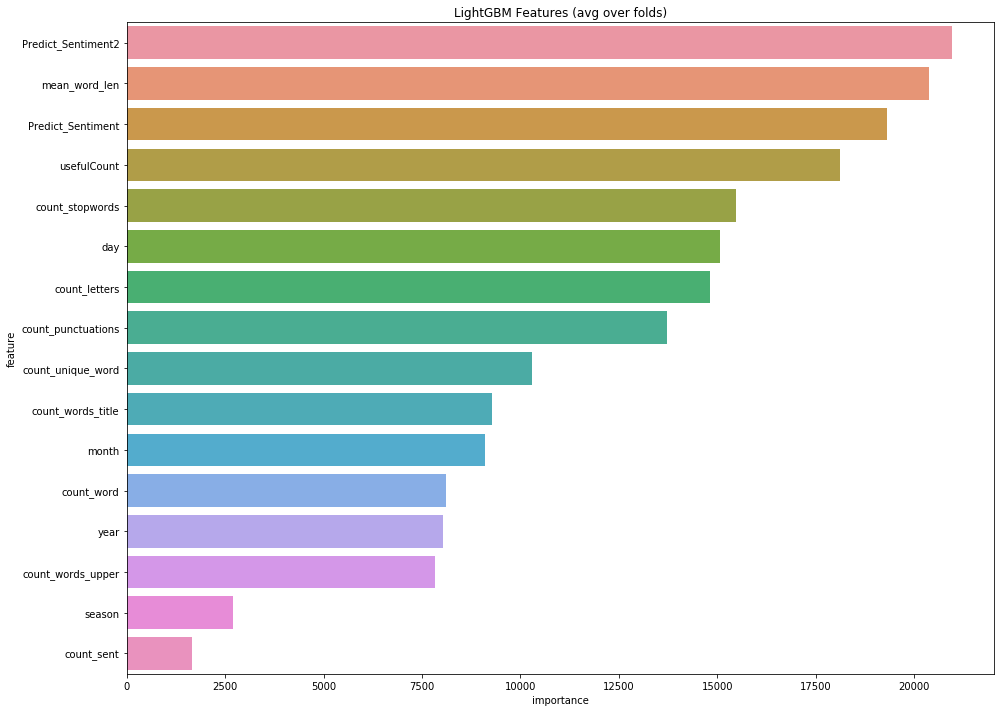

In [66]:
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:50].index

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [67]:
# import dictionary data
word_table = pd.read_csv("inquirerbasic.csv")

In [68]:
##1. make list of sentiment
#Positiv word list   
temp_Positiv = []
Positiv_word_list = []
for i in range(0,len(word_table.Positiv)):
    if word_table.iloc[i,2] == "Positiv":
        temp = word_table.iloc[i,0].lower()
        temp1 = re.sub('\d+', '', temp)
        temp2 = re.sub('#', '', temp1) 
        temp_Positiv.append(temp2)

Positiv_word_list = list(set(temp_Positiv))
len(temp_Positiv)
len(Positiv_word_list)  #del temp_Positiv

#Negativ word list          
temp_Negativ = []
Negativ_word_list = []
for i in range(0,len(word_table.Negativ)):
    if word_table.iloc[i,3] == "Negativ":
        temp = word_table.iloc[i,0].lower()
        temp1 = re.sub('\d+', '', temp)
        temp2 = re.sub('#', '', temp1) 
        temp_Negativ.append(temp2)

Negativ_word_list = list(set(temp_Negativ))
len(temp_Negativ)
len(Negativ_word_list)  #del temp_Negativ

2006

In [69]:
##2. counting the word 98590
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(vocabulary = Positiv_word_list)
content = df_test['review_clean']
X = vectorizer.fit_transform(content)
f = X.toarray()
f = pd.DataFrame(f)
f.columns=Positiv_word_list
df_test["num_Positiv_word"] = f.sum(axis=1)

vectorizer2 = CountVectorizer(vocabulary = Negativ_word_list)
content = df_test['review_clean']
X2 = vectorizer2.fit_transform(content)
f2 = X2.toarray()
f2 = pd.DataFrame(f2)
f2.columns=Negativ_word_list
df_test["num_Negativ_word"] = f2.sum(axis=1)

In [70]:
##3. decide sentiment
df_test["Positiv_ratio"] = df_test["num_Positiv_word"]/(df_test["num_Positiv_word"]+df_test["num_Negativ_word"])
df_test["sentiment_by_dic"] = df_test["Positiv_ratio"].apply(lambda x: 1 if (x>=0.5) else (0 if (x<0.5) else 0.5))

df_test.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,review_clean,sentiment,day,year,month,Predict_Sentiment,Predict_Sentiment2,count_sent,count_word,count_unique_word,count_letters,count_punctuations,count_words_upper,count_words_title,count_stopwords,mean_word_len,season,num_Positiv_word,num_Negativ_word,Positiv_ratio,sentiment_by_dic
147354,126702,Brimonidine,Rosacea,"""Never , never , never use this cream !!!!!! I...",1,2015-08-31,17,never never never use cream help way angri dis...,0,31,2015,8,0.116667,-0.157955,1,58,41,335,58,5,11,54,4.793103,2,NaN,NaN,NaN,0.5
195249,84765,Ethinyl estradiol / norgestimate,Birth Control,"""I was switched to this after about 9 months o...",10,2016-05-01,3,switch month mononessa ask switch happen anywa...,1,1,2016,5,-0.257407,-0.210916,1,50,42,314,27,6,14,50,5.300000,1,NaN,NaN,NaN,0.5
86265,71559,Vraylar,Bipolar Disorde,"""I began at 1.5 then titrated to 3mg dosage. A...",3,2016-08-17,17,began titrat mg dosag first love medicin compl...,0,17,2016,8,0.041667,0.139815,1,41,38,251,20,6,9,41,5.146341,2,NaN,NaN,NaN,0.5
44172,132320,Ativan,Anxiety,"""Ativan 0.5mg calms me down considerably withi...",5,2012-01-12,26,ativan mg calm consider within minut side effe...,0,12,2012,1,-0.170530,-0.061481,1,62,54,353,27,7,8,55,4.709677,4,0.0,4.0,0.0,0.0
90569,177278,Duloxetine,Generalized Anxiety Disorde,"""My thoughts on Cymbalta: Cymbalta has left me...",1,2017-05-03,29,thought cymbalta cymbalta left fog no feel non...,0,3,2017,5,0.071429,-0.122253,2,68,61,395,38,12,19,65,4.823529,1,NaN,NaN,NaN,0.5


In [71]:
def userful_count(data):
    grouped = data.groupby(['condition']).size().reset_index(name='user_size')
    data = pd.merge(data,grouped,on='condition',how='left')
    return data
#___________________________________________________________
df_test =  userful_count(df_test) 
df_test['usefulCount'] = df_test['usefulCount']/df_test['user_size']

In [ ]:
df_test['deep_pred'] = sub_preds_deep
df_test['machine_pred'] = sub_preds

df_test['total_pred'] = (df_test['deep_pred'] + df_test['machine_pred'] + df_test['sentiment_by_dic'])*df_test['usefulCount']

In [ ]:
df_test = df_test.groupby(['condition','drugName']).agg({'total_pred' : ['mean']})
df_test

### Machine Learning Models¶
#### Classification with sk-learn and Random Forests

In [74]:
# Creates TF-IDF vectorizer and transforms the corpus
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(df_train.review)

# transforms test reviews to above vectorized format
X_test = vectorizer.transform(df_test.review)

In [77]:
from sklearn.naive_bayes import MultinomialNB
# Create a column with binary rating indicating the polarity of a review
df_train['binary_rating'] = df_train['rating'] > 5

y_train_rating = df_train.binary_rating
clf = MultinomialNB().fit(X_train, y_train_rating)

# Evaluates model on test set
df_test['binary_rating'] = df_test.rating > 5
y_test_rating = df_test.binary_rating
pred = clf.predict(X_test)

print("Accuracy: %s" % str(clf.score(X_test, y_test_rating)))
print("Confusion Matrix")
print(confusion_matrix(pred, y_test_rating))

Accuracy: 0.7512218125696648
Confusion Matrix
[[ 3997   397]
 [17012 48572]]


In [80]:
import time
from sklearn.ensemble import RandomForestClassifier
# Trains random forest classifier
start = time.time()
rfc_rating = RandomForestClassifier(n_estimators=100, random_state=42, max_depth = 10000, min_samples_split = 0.001)
rfc_rating.fit(X_train, y_train_rating)
end = time.time()
print("Training time: %s" % str(end-start))

# Evaluates model on test set
pred = rfc_rating.predict(X_test)

print("Accuracy: %s" % str(rfc_rating.score(X_test, y_test_rating)))
print("Confusion Matrix")
print(confusion_matrix(pred, y_test_rating))

Training time: 401.00926184654236
Accuracy: 0.8285604046986196
Confusion Matrix
[[ 9214   202]
 [11795 48767]]


#### Classification with Keras

In [81]:
b = "'@#$%^()&*;!.-"
X_train = np.array(df_train['review'])
X_test = np.array(df_test['review'])

def clean(X):
    for index, review in enumerate(X):
        for char in b:
            X[index] = X[index].replace(char, "")
    return(X)

X_train = clean(X_train)
X_test = clean(X_test)
print(X_train[:2])

['"After trying nearly every SSRI on the market I was placed on Pristiq, which improved my condition somewhat, but still left me dependent on Xanax to alleviate my daily anxiety After a particularly bad stretch I was also placed on Seroquel XR It has helped more than I could have ever hoped for I finally don039t have to reach for a Xanax as soon as I wake up It was very sedating for the first week after I started, and after increasing my dosage, but this has lessened with time I do make sure to take it before bed, as it does make me tired as it kicks in, but I welcome this due to my problems with insomnia"'
 '"This takes 6+ months, but did clear up a decades long infection"']


In [82]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from keras.utils import to_categorical
from gensim.models import Word2Vec
from nltk.cluster import KMeansClusterer
import nltk

vectorizer = CountVectorizer(binary=True, stop_words=stopwords.words('english'),lowercase=True, max_features=5000)
#vectorizer = TfidfVectorizer(binary=True, stop_words=stopwords.words('english'), lowercase=True, max_features=5000)
test_train = np.concatenate([X_train, X_test])
print(test_train.shape)
X_onehot = vectorizer.fit_transform(test_train)
stop_words = vectorizer.get_stop_words()
print(type(X_onehot))

(212053,)
<class 'scipy.sparse.csr.csr_matrix'>


In [83]:
print(X_onehot.shape)
print(X_onehot.toarray())

(212053, 5000)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [84]:
names_list = vectorizer.get_feature_names()
names = [[i] for i in names_list]
names = Word2Vec(names, min_count=1)
print(len(list(names.wv.vocab)))
print(list(names.wv.vocab)[:5])

5000
['00', '000', '00am', '00pm', '01']


In [85]:
def score_transform(X):
    y_reshaped = np.reshape(X['rating'].values, (-1, 1))
    for index, val in enumerate(y_reshaped):
        if val >= 8:
            y_reshaped[index] = 1
        elif val >= 5:
            y_reshaped[index] = 2
        else:
            y_reshaped[index] = 0
    y_result = to_categorical(y_reshaped)
    return y_result
    
    print(X_onehot)

In [86]:
y_train_test = pd.concat([df_train, df_test], ignore_index=True)
y_train = score_transform(y_train_test)
print(y_train)
print(y_train.shape)

[[0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]
(212053, 3)


In [87]:
from numpy.random import seed

np.random.seed(1)
model = Sequential()
model.add(Dense(units=256, activation='relu', input_dim=len(vectorizer.get_feature_names())))
model.add(Dense(units=3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary

<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x000001E74FE87088>>

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
scores = model.evaluate(X_onehot[157482:], y_train[157482:], verbose=1)

In [ ]:
scores[1]

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [90]:
all_names = [i.split() for i in X_train]

In [ ]:
np.random.seed(1)
all_names_rand = [all_names[np.random.randint(low=1, high=150000)] for i in range(5000)]
print(len(all_names_rand))

In [ ]:
all_names_list = Word2Vec(all_names_rand, min_count=1)
all_names_vec = all_names_list[all_names_list.wv.vocab]
print(all_names[0])

In [ ]:
kclusterer_all = KMeansClusterer(5, distance=nltk.cluster.util.cosine_distance, repeats=10)
assigned_clusters_all = kclusterer_all.cluster(all_names_vec, assign_clusters=True)
print(len(assigned_clusters_all))

In [ ]:
def generate_df(feature_names): 
    
    #  creates a zipped dictionary with every word from all of the reviews as a key and its assigned cluster as its value
    all_words_dict = dict(zip(all_names_list.wv.vocab, assigned_clusters_all))
    
    #iterates through and deletes any word that isn't a feature.
    for key in list(all_words_dict.keys()):
        if key in list(feature_names):
            pass
        else:
            del all_words_dict[key]
            
    #dictionary is then converted into nested list, with each inner list corresponding to one cluster.
    sorted_names = []
    for cluster in range(5):
        cluster_list = []
        for key, value in all_words_dict.items():
            if value == cluster:
                cluster_list.append(key)
        sorted_names.append(cluster_list)
        
    #inner list word features are sorted alphabetically then converted into a pandas DataFrame.
    for index, entry in enumerate(sorted_names):
        entry.sort()
    
    df_all = pd.DataFrame(sorted_names).T
    print(df_all[:50])
    
    #returns pandas dataframe with each cluster as a column and a list of lists where each list is all of the words assigned to that cluster.
    return df_all, sorted_names
    


In [ ]:
def test_clusters(cluster_list):
    #function iterates through a list of lists. these lists contain names of the feature words we want to test our model with.
    
    #score_list for accuracy of each cluster on model.
    score_list = []
    lens = []
    
    #number of reviews tested on.
    reviewnum = 15000
    
    #random sampling of reviews.
    np.random.seed(3)
    indicies = [np.random.randint(low=1, high=150000) for i in range(reviewnum)]
    X_sample =  test_train[indicies]
    y_sample = y_train[indicies]
    
    #beginning iteration through words per list.
    for cluster in cluster_list:
        
        #appending length for print statement at the end.
        lens.append(len(cluster))

        X_onehot = vectorizer.fit_transform(X_sample)
        
        X_onehot = X_onehot.toarray()

        cluster_indexes = []

        #if the feature name in the feature vocab is found in the cluster, the index is appended to the cluster index list.
        for index, feature_name in enumerate(list(names.wv.vocab)):
            if feature_name in cluster:
                cluster_indexes.append(index)

        #amount of features for the input layer dimension of the neural net
        features = len(cluster_indexes)
        
        #creating specific X_onehot matrix with only columns of corresponding vector columns
        X_onehot = X_onehot[:, cluster_indexes]

        model_cluster = Sequential()
        model_cluster.add(Dense(units=256, activation='relu', input_dim=features))
        model_cluster.add(Dense(units=3, activation='softmax'))

        model_cluster.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        model_cluster.summary
        
        #indexing so 2000 reviews are saved for testing
        history = model_cluster.fit(X_onehot[:reviewnum-2000], y_sample[:reviewnum-2000], epochs=10, batch_size=128, verbose=2, validation_data=(X_onehot[reviewnum-2000:reviewnum-1900], y_sample[reviewnum-2000:reviewnum-1900]))
        
        y_test = score_transform(test)
        scores = model_cluster.evaluate(X_onehot[reviewnum-2000:], y_sample[reviewnum-2000:], verbose=1)
        
        #score of model is appended to list returned at the end
        score_list.append(scores[1])
    for index, entry in enumerate(score_list):
        print("cluster", index + 1, "accuracy: ", str(entry) + ". number of words for cluster: ", lens[index])

In [ ]:
test_clusters([list(names.wv.vocab)[:1000], list(names.wv.vocab)[2000:3000], list(names.wv.vocab)[3000:4000], list(names.wv.vocab)[4000:5000]])

In [ ]:
vectorizer = CountVectorizer(binary=True, stop_words=stopwords.words('english'),
                             lowercase=True, min_df=3, max_df=0.9, max_features=1000)
X_onehot = vectorizer.fit_transform(test_train)
names_list = vectorizer.get_feature_names()
names = [[i] for i in names_list]
names = Word2Vec(names, min_count=1)

df, sorted_names_all = generate_df(names.wv.vocab)

In [ ]:
test_clusters(sorted_names_all)

#### Simple Regression with sk-learn

In [94]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

#Reimporting data due to all of the weird transformations that have been applied to our original X_train as well as different variable names

train = pd.read_csv('drugsComTrain_raw.csv')
test = pd.read_csv('drugsComTest_raw.csv')

# Get review text
reviews = np.vstack((train.review.values.reshape(-1, 1), 
                     test.review.values.reshape(-1, 1)))

# Set up function to re-vectorize reviews. This time binary is set to false, we only have 500 max features and min and max_df arguments have been set.
vectorizer = CountVectorizer(binary=False, stop_words=stopwords.words('english'),
                             lowercase=True, min_df=3, max_df=0.9, max_features=500)

# Vectorize reviews
X = vectorizer.fit_transform(reviews.ravel()).toarray()

# Get ratings
ratings = np.concatenate((train.rating.values, test.rating.values)).reshape(-1, 1)

y = ratings

X_train, X_test = X[:train.values.shape[0], :], X[train.values.shape[0]:, :] 
y_train, y_test = y[:train.values.shape[0]], y[train.values.shape[0]:]

In [95]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train[:5000], y_train[:5000])

LinearRegression()

In [96]:
pred = lin_reg.predict(X_train[5000:])

In [97]:
np.sum(np.abs(y_train[5000:] - pred[:])) / (161297 - 5000)

2.3219019288767733

In [99]:
# Dictionary_Sentiment_Analysis
# Because the package used for prediction of 'Predict value' is formed with movie review data, it can be unsuitable for this project which analyzes reviews
# for drugs. To make up for this, we conducted additional emotional analysis using the Harvard emotional dictionary.

# import dictionary data
word_table = pd.read_csv("inquirerbasic.csv")

# checking the head of the dictionary
word_table.head(10)

,Entry,Source,Positiv,Negativ
0,A,H4Lvd,NaN,NaN
1,ABANDON,H4Lvd,NaN,Negativ
2,ABANDONMENT,H4,NaN,Negativ
3,ABATE,H4Lvd,NaN,Negativ
4,ABATEMENT,Lvd,NaN,NaN
5,ABDICATE,H4,NaN,Negativ
6,ABHOR,H4,NaN,Negativ
7,ABIDE,H4,Positiv,NaN
8,ABILITY,H4Lvd,Positiv,NaN
9,ABJECT,H4,NaN,Negativ


In [100]:
# make list of sentiment
#Positiv word list   

temp_Positiv = []
Positiv_word_list = []
for i in range(0,len(word_table.Positiv)):
    if word_table.iloc[i,2] == "Positiv":
        temp = word_table.iloc[i,0].lower()
        temp1 = re.sub('\d+', '', temp)
        temp2 = re.sub('#', '', temp1) 
        temp_Positiv.append(temp2)

Positiv_word_list = list(set(temp_Positiv))
len(temp_Positiv)
len(Positiv_word_list)

1637

In [101]:
#Negativ word list 

temp_Negativ = []
Negativ_word_list = []
for i in range(0,len(word_table.Negativ)):
    if word_table.iloc[i,3] == "Negativ":
        temp = word_table.iloc[i,0].lower()
        temp1 = re.sub('\d+', '', temp)
        temp2 = re.sub('#', '', temp1) 
        temp_Negativ.append(temp2)

Negativ_word_list = list(set(temp_Negativ))
len(temp_Negativ)
len(Negativ_word_list)

2006

In [102]:
##2. counting the word 98590

import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(vocabulary = Positiv_word_list)
content = df_test['review_clean']
X = vectorizer.fit_transform(content)
f = X.toarray()
f = pd.DataFrame(f)
f.columns=Positiv_word_list
df_test["num_Positiv_word"] = f.sum(axis=1)

vectorizer2 = CountVectorizer(vocabulary = Negativ_word_list)
content = df_test['review_clean']
X2 = vectorizer2.fit_transform(content)
f2 = X2.toarray()
f2 = pd.DataFrame(f2)
f2.columns=Negativ_word_list
df_test["num_Negativ_word"] = f2.sum(axis=1)

In [103]:

# decide sentiment
df_test["Positiv_ratio"] = df_test["num_Positiv_word"]/(df_test["num_Positiv_word"]+df_test["num_Negativ_word"])
df_test["sentiment_by_dic"] = df_test["Positiv_ratio"].apply(lambda x: 1 if (x>=0.5) else (0 if (x<0.5) else 0.5))

df_test.head()


,uniqueID,drugName,condition,review,rating,date,usefulCount,review_clean,sentiment,day,year,month,Predict_Sentiment,Predict_Sentiment2,count_sent,count_word,count_unique_word,count_letters,count_punctuations,count_words_upper,count_words_title,count_stopwords,mean_word_len,season,num_Positiv_word,num_Negativ_word,Positiv_ratio,sentiment_by_dic,user_size,binary_rating
0,126702,Brimonidine,Rosacea,"""Never , never , never use this cream !!!!!! I...",1,2015-08-31,0.073593,never never never use cream help way angri dis...,0,31,2015,8,0.116667,-0.157955,1,58,41,335,58,5,11,54,4.793103,2,6,8,0.428571,0.0,231,False
1,84765,Ethinyl estradiol / norgestimate,Birth Control,"""I was switched to this after about 9 months o...",10,2016-05-01,0.000236,switch month mononessa ask switch happen anywa...,1,1,2016,5,-0.257407,-0.210916,1,50,42,314,27,6,14,50,5.300000,1,0,6,0.000000,0.0,12685,True
2,71559,Vraylar,Bipolar Disorde,"""I began at 1.5 then titrated to 3mg dosage. A...",3,2016-08-17,0.009224,began titrat mg dosag first love medicin compl...,0,17,2016,8,0.041667,0.139815,1,41,38,251,20,6,9,41,5.146341,2,4,6,0.400000,0.0,1843,False
3,132320,Ativan,Anxiety,"""Ativan 0.5mg calms me down considerably withi...",5,2012-01-12,0.009973,ativan mg calm consider within minut side effe...,0,12,2012,1,-0.170530,-0.061481,1,62,54,353,27,7,8,55,4.709677,4,5,10,0.333333,0.0,2607,False
4,177278,Duloxetine,Generalized Anxiety Disorde,"""My thoughts on Cymbalta: Cymbalta has left me...",1,2017-05-03,0.055238,thought cymbalta cymbalta left fog no feel non...,0,3,2017,5,0.071429,-0.122253,2,68,61,395,38,12,19,65,4.823529,1,6,11,0.352941,0.0,525,False
